# Next-item recommendation on top of Amason’s explicit rating dataset

Frame the recommendation system as a rating prediction machine learning problem and create a hybrid architecture that mixes the collaborative and content based filtering approaches:
- Collaborative part: Predict items ratings in order to recommend to the user items that he is likely to rate high.
- Content based: use metadata inputs (such as price and title) about items to find similar items to recommend.

Create 2 explicit recommendation engine models based on 2 machine learning architecture using Keras: a matrix factorization model and a deep neural network model.

For training validation and prediction, I used the electronics reviews dataset from amazon which contains explicit item ranking

Compare the results of the different models and configurations to find the "best" predicting model

I used the best model for recommending items to users

In [1]:
%pylab inline
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
import re
import seaborn as sbn
import nltk
import tqdm as tqdm
import sqlite3
import pandas as pd
import numpy as np
from pandas import DataFrame 
import string

import matplotlib.pyplot as plt
from math import floor,ceil

#from nltk.corpus import stopwords
#stop = stopwords.words("english")
from nltk.stem.porter import PorterStemmer
english_stemmer=nltk.stem.SnowballStemmer('english')
from nltk.tokenize import word_tokenize

from sklearn.metrics import accuracy_score, confusion_matrix,roc_curve, auc,classification_report, mean_squared_error, mean_absolute_error
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection  import train_test_split
from sklearn import metrics
from sklearn.svm import LinearSVC
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LogisticRegression
from sklearn import neighbors
from scipy.spatial.distance import cosine
from sklearn.feature_selection import SelectKBest
from IPython.display import SVG
import pydot 
import pydotplus
import pydot_ng
import pickle
import time
import gzip
import os
os.getcwd()

Populating the interactive namespace from numpy and matplotlib


'C:\\Users\\Irit\\Google Drive (iritfh2@gmail.com)\\jupiterNotebooks'

In [2]:
# Tensorflow
import tensorflow as tf

#Keras
from keras.models import Sequential, Model, load_model, save_model
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Activation, Dropout, Input, Masking, TimeDistributed, LSTM, Conv1D, Embedding
from keras.layers import GRU, Bidirectional, BatchNormalization, Reshape
from keras.optimizers import Adam

from keras.layers.core import Reshape, Dropout, Dense
from keras.layers.merge import Multiply, Dot, Concatenate
from keras.layers.embeddings import Embedding
from keras import optimizers
from keras.callbacks import ModelCheckpoint
from keras.utils.vis_utils import model_to_dot



Using TensorFlow backend.


In [3]:
#Session
from keras import backend as K
cfg = K.tf.ConfigProto()
cfg.gpu_options.per_process_gpu_memory_fraction =1 # allow all of the GPU memory to be allocated
cfg.gpu_options.visible_device_list = "0" # "0,1"
#cfg.gpu_options.allow_growth = True  # # Don't pre-allocate memory; dynamically allocate the memory used on the GPU as-needed
#cfg.log_device_placement = True  # to log device placement (on which device the operation ran)
sess = K.tf.Session(config=cfg)
K.set_session(sess)  # set this TensorFlow session as the default session for Keras


In [4]:
## Read the input and convert ro DF
def parse_gz(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield eval(l)

def convert_to_DF(path):
    i = 0
    df = {}
    for d in parse_gz(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

In [5]:
# reset GPU memory& Keras Session
def reset_keras():
    try:
        del classifier
        del model    
    except:
        pass

    K.clear_session()
 
    K.get_session().close()
#    sess = K.get_session()

    cfg = K.tf.ConfigProto()
    cfg.gpu_options.per_process_gpu_memory_fraction 
    cfg.gpu_options.visible_device_list = "0" # "0,1"
    cfg.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU

    sess = K.tf.Session(config=cfg)
    K.set_session(sess)  # set this TensorFlow session as the default session for Keras
    

#### Download and prepare Data:
###### 1. Read the data:
Read the data from the electronics reviews dataset of amazon. Use the dastaset in which all users and items have at least 5 reviews ("small" dataset), or a sample of all the reviews regardless of reviews number ("large" dataset).



In [6]:
review_data = convert_to_DF('reviews_Electronics_ 5_reviews.json.gz')
print('Dataset size: {:,} rows'.format(len(review_data)))

Dataset size: 1,689,188 rows


In [7]:
review_data[:3]

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,AO94DHGC771SJ,0528881469,amazdnu,"[0, 0]",We got this GPS for my husband who is an (OTR)...,5.0,Gotta have GPS!,1370131200,"06 2, 2013"
1,AMO214LNFCEI4,0528881469,Amazon Customer,"[12, 15]","I'm a professional OTR truck driver, and I bou...",1.0,Very Disappointed,1290643200,"11 25, 2010"
2,A3N7T0DY83Y4IG,0528881469,C. A. Freeman,"[43, 45]","Well, what can I say. I've had this unit in m...",3.0,1st impression,1283990400,"09 9, 2010"


In [8]:
review_data.shape

(1689188, 9)

Thus I have 1,689,188 rows and 9 columns in the "small" dataset, and 7,824,482 rows and 9 columns in the "large" dataset.

###### 2. Arrange and clean the data

Rearrange the columns by relevance and rename column names

In [9]:
review_data=review_data.drop(['helpful','unixReviewTime'],axis=1)

review_data = review_data[['asin', 'summary', 'reviewText', 'overall', 'reviewerID', 'reviewerName', 'reviewTime']]

review_data.rename(columns={ 'overall': 'score','reviewerID': 'user_id', 'reviewerName': 'user_name'}, inplace=True)

#the variables names after rename in the modified data frame
list(review_data)

['asin',
 'summary',
 'reviewText',
 'score',
 'user_id',
 'user_name',
 'reviewTime']

## The Data
###### The datasets are composed of:

“item_id”(“asin”): a unique id for an item - Independent explanatory variable

“user_id”: a unique id for a user -Independent explanatory variable

“score”(“overall”): the review score, between 1 and 5 - The dependent variable I want to predict

“user_name”: the name of the user.

“reviewTime”: the date when the user posted the review. Will not be used in this work.

“reviewText”: For some entries, there is also a typed review. Will not be used in this work.

“summary”: summary of the review. Will not be used in this work.

 

$\underline{Investigate}$:

In [10]:
# Ratings distribution using pandas:
review_data["score"] = review_data["score"].fillna(review_data["score"].median()) 
review_data["score"].describe()

count    1.689188e+06
mean     4.222779e+00
std      1.185632e+00
min      1.000000e+00
25%      4.000000e+00
50%      5.000000e+00
75%      5.000000e+00
max      5.000000e+00
Name: score, dtype: float64

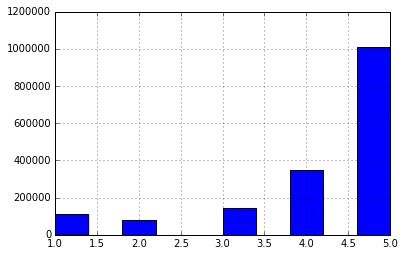

In [11]:
# Plot the distribution
review_data["score"].hist(bins=10)

The median in both datasets is 5. This means that the data is skewed towards high ratings. 
This is a common bias in internet ratings, where people tend to rate items that they liked, and rarely spend time to comment something they dislike or are indiferent to. This will have a huge impact on the way I model the recommendation problem.

###### Key conclusions from above: 

Reviews are skewed towards positive

Many people agree with score 5 reviews


## Add metadata 

In [12]:
all_info = convert_to_DF('meta_Electronics.json.gz')
print('metadata dataset size: {:,} rows'.format(len(all_info)))

metadata dataset size: 498,196 rows


###### Arrange and clean the data

Cleaning, handling missing data, normalization, etc:

For the algorithm in keras to work,  remap all item_ids and user_ids to an interger between 0 and the total number of users or the total number of items



In [13]:
items = all_info.asin.unique()
item_map = {i:val for i,val in enumerate(items)}
inverse_item_map = {val:i for i,val in enumerate(items)}
all_info["old_item_id"] = all_info["asin"] # copying for join with metadata
all_info["item_id"] = all_info["asin"].map(inverse_item_map)
items = all_info.item_id.unique()
print ("We have %d unique items in metadata "%items.shape[0])

We have 498196 unique items in metadata 


In [14]:
all_info['description'] = all_info['description'].fillna(all_info['title'].fillna('no_data'))
all_info['title'] = all_info['title'].fillna(all_info['description'].fillna('no_data').apply(str).str[:20])
all_info['salesRank'] = all_info['salesRank'].fillna('no_data')
all_info['price'] = pd.to_numeric(all_info['price'],errors="coerce")
all_info['price'] = all_info['price'].fillna(all_info['price'].median()) 

In [15]:
users = review_data.user_id.unique()
user_map = {i:val for i,val in enumerate(users)}
inverse_user_map = {val:i for i,val in enumerate(users)}
review_data["old_user_id"] = review_data["user_id"] 
review_data["user_id"] = review_data["user_id"].map(inverse_user_map)

items_reviewed = review_data.asin.unique()
review_data["old_item_id"] = review_data["asin"] # copying for join with metadata
review_data["item_id"] = review_data["asin"].map(inverse_item_map)

items_reviewed = review_data.item_id.unique()
users = review_data.user_id.unique()

In [16]:
print ("We have %d unique users"%users.shape[0])
print ("We have %d unique items reviewed"%items_reviewed.shape[0])
# We have 192403 unique users in the "small" dataset
# We have 63001 unique items reviewed in the "small" dataset

We have 192403 unique users
We have 63001 unique items reviewed


In [17]:
review_data.head(3)

,asin,summary,reviewText,score,user_id,user_name,reviewTime,old_user_id,old_item_id,item_id
0,0528881469,Gotta have GPS!,We got this GPS for my husband who is an (OTR)...,5.0,0,amazdnu,"06 2, 2013",AO94DHGC771SJ,0528881469,4
1,0528881469,Very Disappointed,"I'm a professional OTR truck driver, and I bou...",1.0,1,Amazon Customer,"11 25, 2010",AMO214LNFCEI4,0528881469,4
2,0528881469,1st impression,"Well, what can I say. I've had this unit in m...",3.0,2,C. A. Freeman,"09 9, 2010",A3N7T0DY83Y4IG,0528881469,4




$\underline{Investigate}$:

###### Check the Distribution of number of ratings per user:

In [18]:
users_ratings = review_data['old_user_id'].value_counts().reset_index()
users_ratings.columns= ['old_user_id','num_ratings']
users_ratings['num_ratings'].describe()

count    192403.000000
mean          8.779427
std           8.263942
min           5.000000
25%           5.000000
50%           7.000000
75%           9.000000
max         431.000000
Name: num_ratings, dtype: float64

The distribution of number of ratings per user is very skewed in both datasets, with 50% of people having done a small number of reviews, and few made many ratings. I will check if it gives us enough information for generating good recommendations.

###### Check the Distribution of the number of ratings per item:

In [19]:
#items_nb = review_data['old_item_id'].value_counts().reset_index()
items_avg = review_data.drop(['summary','reviewText','user_id','asin','user_name','reviewTime','old_user_id','item_id'],axis=1).groupby('old_item_id').agg(['count','mean']).reset_index()
items_avg.columns= ['old_item_id','num_ratings','avg_rating']
#items_avg.head(5)
items_avg['num_ratings'].describe()

count    63001.000000
mean        26.812082
std         75.821107
min          5.000000
25%          7.000000
50%         11.000000
75%         22.000000
max       4915.000000
Name: num_ratings, dtype: float64

Again, the distribution of number of ratings per item is very skewed in both datasets, with 50% of the items having a small number of ratings whereas few got many ratings. 
I will check if the distribution of items rating is good enough to generate good recommendations.

###### Adding the review count and avarage to the metadata

In [20]:
all_info =  pd.merge(all_info,items_avg,how='left',left_on='asin',right_on='old_item_id')
pd.set_option('display.max_colwidth', 100)
all_info.head(2)

,asin,imUrl,description,categories,title,price,salesRank,related,brand,old_item_id_x,item_id,old_item_id_y,num_ratings,avg_rating
0,0132793040,http://ecx.images-amazon.com/images/I/31JIPhp%2BGIL.jpg,The Kelby Training DVD Mastering Blend Modes in Adobe Photoshop CS5 with Corey Barker is a usefu...,"[[Electronics, Computers & Accessories, Cables & Accessories, Monitor Accessories]]",Kelby Training DVD: Mastering Blend Modes in Adobe Photoshop CS5 By Corey Barker,19.99,no_data,NaN,NaN,0132793040,0,NaN,NaN,NaN
1,0321732944,http://ecx.images-amazon.com/images/I/31uogm6YcrL.jpg,Kelby Training DVD: Adobe Photoshop CS5 Crash Course By Matt Kloskowski,"[[Electronics, Computers & Accessories, Cables & Accessories, Monitor Accessories]]",Kelby Training DVD: Adobe Photoshop CS5 Crash Course By Matt Kloskowski,19.99,no_data,NaN,NaN,0321732944,1,NaN,NaN,NaN


Top 10 Reviewed Products

In [21]:
print("Top 10 Reviewed Products:\n")
all_info[['asin','item_id','title','avg_rating','num_ratings']].sort_values('num_ratings',ascending=False).head(10)

Top 10 Reviewed Products:



,asin,item_id,title,avg_rating,num_ratings
336534,B007WTAJTO,336534,"SanDisk Ultra 64GB MicroSDXC Class 10 UHS Memory Card Speed Up To 30MB/s With Adapter, Frustrati...",4.587589,4915.0
182679,B003ES5ZUU,182679,AmazonBasics High-Speed HDMI Cable - 15 Feet ( 4.6 Meters) Supports Ethernet,4.800386,4143.0
446484,B00DR0PDNE,446484,Google Chromecast HDMI Streaming Media Player,3.997894,3798.0
104373,B0019EHU8G,104373,"Mediabridge ULTRA Series HDMI Cable (6 Feet) - High-Speed Supports Ethernet, 3D and Audio Return...",4.801164,3435.0
162157,B002WE6D44,162157,Transcend 8 GB Class 10 SDHC Flash Memory Card (TS8GSDHC10E),4.659794,2813.0
182462,B003ELYQGG,182462,"Panasonic RPHJE120D In-Ear Headphone, Orange",4.355958,2652.0
30679,B0002L5R78,30679,DVI Gear HDMI Cable 2M 6 feet,4.599846,2599.0
384694,B009SYZ8OC,384694,AmazonBasics Apple Certified Lightning to USB Cable - 3 Feet (0.9 Meter) - Black,4.444925,2542.0
415964,B00BGGDVOO,415964,Roku 3 Streaming Media Player,4.421578,2104.0
161013,B002V88HFE,161013,eneloop SEC-CSPACER4PK C Size Spacers for use with AA battery cells,4.736311,2082.0


Check how many rows contain empty columns

In [22]:
a = review_data.dropna()[['item_id','user_id','score']]
#a.shape[0] / float(review_data.shape[0]) ## 1664458 /1689188.0

In [23]:
b = all_info.dropna()[['item_id','price']]
#b.shape[0] / float(all_info.shape[0]) ## 1664458 /1689188.0

Get the bottom rated items that are rated more than 500 times.

In [24]:
all_info[all_info['num_ratings']>=500][['asin','title','avg_rating','num_ratings']].sort_values('avg_rating',ascending=True).head(5)

,asin,title,avg_rating,num_ratings
160150,B002UT42UI,Eye-Fi Pro X2 8 GB Class 6 SDHC Wireless Flash Memory Card EYE-FI-8PC,3.543599,539.0
242473,B004OB0EBQ,SANOXY 7&quot; Tablet Stand with USB Keyboard - Black Faux Leather Carrying Case,3.601318,607.0
62110,B000I68BD4,JLab JBuds Hi-Fi Noise-Reducing Ear Buds (White),3.718075,1018.0
37200,B0007MXZB2,Terk HDTVa Indoor Amplified High-Definition Antenna for Off-Air HDTV Reception,3.769492,590.0
313503,B006ZP8UOW,Foscam FI8910W Pan &amp; Tilt IP/Network Camera with Two-Way Audio and Night Vision (Black),3.806452,961.0


Look at the top items rated more than 3000 times

In [25]:
all_info[all_info['num_ratings']>=3000][['asin','title','avg_rating','num_ratings']].sort_values('avg_rating',ascending=False).head(5)

,asin,title,avg_rating,num_ratings
104373,B0019EHU8G,"Mediabridge ULTRA Series HDMI Cable (6 Feet) - High-Speed Supports Ethernet, 3D and Audio Return...",4.801164,3435.0
182679,B003ES5ZUU,AmazonBasics High-Speed HDMI Cable - 15 Feet ( 4.6 Meters) Supports Ethernet,4.800386,4143.0
336534,B007WTAJTO,"SanDisk Ultra 64GB MicroSDXC Class 10 UHS Memory Card Speed Up To 30MB/s With Adapter, Frustrati...",4.587589,4915.0
446484,B00DR0PDNE,Google Chromecast HDMI Streaming Media Player,3.997894,3798.0


After investigating and having a good overview of the data. Let's start recommending the items

# Explicit feedback Recommender System

Explicit feedback is when users gives voluntarily the rating information on what they like and dislike.

In this case, I have explicit item ratings ranging from one to five.

I framed the recommendation system as a rating prediction machine learning problem: 
Predict an item's ratings in order to be able to recommend to a user an item that he is likely to rate high if he buys it. 

###### To evaluate the model, I randomly separate the data into a training and test set. 

In [26]:
ratings_train, ratings_test = train_test_split( review_data, test_size=0.1, random_state=0)

### Adding Metadata to the train set
Create an architecture that mixes the collaborative and content based filtering approaches:
- Collaborative Part: Predict items ratings to recommend to the user items which he is likely to rate high according to learnt item & user embeddings (learn similarity from interactions).
- Content based part: Use metadata inputs (such as price and title) about items to recommend to the user contents similar to those he rated high (learn similarity of item attributes).

###### Adding the title and price
Add the metadata of the items in the training and test datasets.

In [27]:
# creating metadata mappings 
titles = all_info['title'].unique()
titles_map = {i:val for i,val in enumerate(titles)}
inverse_titles_map = {val:i for i,val in enumerate(titles)}

price = all_info['price'].unique()
price_map = {i:val for i,val in enumerate(price)}
inverse_price_map = {val:i for i,val in enumerate(price)}

print ("We have %d prices" %price.shape)
print ("We have %d titles" %titles.shape)


all_info['price_id'] = all_info['price'].map(inverse_price_map)
all_info['title_id'] = all_info['title'].map(inverse_titles_map)

# creating dict from 
item2prices = {}
for val in all_info[['item_id','price_id']].dropna().drop_duplicates().iterrows():
    item2prices[val[1]["item_id"]] = val[1]["price_id"]

item2titles = {}
for val in all_info[['item_id','title_id']].dropna().drop_duplicates().iterrows():
    item2titles[val[1]["item_id"]] = val[1]["title_id"]
        


# populating the rating dataset with item metadata info
ratings_train["price_id"] = ratings_train["item_id"].map(lambda x : item2prices[x])
ratings_train["title_id"] = ratings_train["item_id"].map(lambda x : item2titles[x])


# populating the test dataset with item metadata info
ratings_test["price_id"] = ratings_test["item_id"].map(lambda x : item2prices[x])
ratings_test["title_id"] = ratings_test["item_id"].map(lambda x : item2titles[x])


We have 22166 prices
We have 486754 titles


In [28]:
ratings_train[:3]

,asin,summary,reviewText,score,user_id,user_name,reviewTime,old_user_id,old_item_id,item_id,price_id,title_id
132804,B0006IWXOC,Great cam,"Great camera. Works perfect for monitoring my front door, as I do live in the city, and receive ...",5.0,75316,"DOC HOLIDAY ""DOC""","07 9, 2013",A394FOR62LMMXO,B0006IWXOC,34872,1511,34664
1329935,B007SZ0E1K,Finally bought an Intel CPU and I love it,I've been using hand-me-down AMD cpus for a long time as I haven't had money for my own expensiv...,5.0,10882,roman310,"09 22, 2013",A1JBMZRN6M3NKC,B007SZ0E1K,333736,5763,326376
621954,B002LPV6LY,raised the white flag,"I've been around computers since '89. After sinking about 8 hours on trying to get it to work, I...",2.0,115262,G.C.,"09 9, 2011",A1VS1P6A7D4FNE,B002LPV6LY,150437,10301,148741


In [29]:
ratings_train.shape

(1520269, 12)

Thus we have 1,520,269 rows and 12 columns in train set



### Define embeddings
The $\underline{embeddings}$ are low-dimensional hidden representations of users and items, i.e. for each item I can find its properties and for each user I can encode how much they like those properties so I can determine attitudes or preferences of users by a small number of hidden factors 

Throughout the training, I learn two new low-dimensional dense representations: one embedding for the users and another one for the items.


In [30]:
#  declare input embeddings to the model
#User input
user_id_input = Input(shape=[1], name='user')
#Item Input
item_id_input = Input(shape=[1], name='item')
price_id_input = Input(shape=[1], name='price')
title_id_input = Input(shape=[1], name='title')

# define the size of embeddings as a parameter
user_embedding_size = 15 # Check 5, 10 , 15, 20, 50
item_embedding_size = 15 # Check 5, 10 , 15, 20, 50
price_embedding_size = 15 # Check 5, 10 , 15, 20, 50
title_embedding_size = 15 # Check 5, 10 , 15, 20, 50

# apply an embedding layer to all inputs
user_embedding = Embedding(output_dim=user_embedding_size, input_dim=users.shape[0],
                               input_length=1, name='user_embedding')(user_id_input)

item_embedding = Embedding(output_dim=item_embedding_size, input_dim=items_reviewed.shape[0],
                               input_length=1, name='item_embedding')(item_id_input)

price_embedding = Embedding(output_dim=price_embedding_size, input_dim=price.shape[0],
                           input_length=1, name='price_embedding')(price_id_input)

title_embedding = Embedding(output_dim=title_embedding_size, input_dim=titles.shape[0],
                           input_length=1, name='title_embedding')(title_id_input)

# reshape from shape (batch_size, input_length,embedding_size) to (batch_size, embedding_size). 
user_vecs = Reshape([user_embedding_size])(user_embedding)
item_vecs = Reshape([item_embedding_size])(item_embedding)
price_vecs = Reshape([price_embedding_size])(price_embedding)
title_vecs = Reshape([title_embedding_size])(title_embedding)

### Applying matrix factorization approach
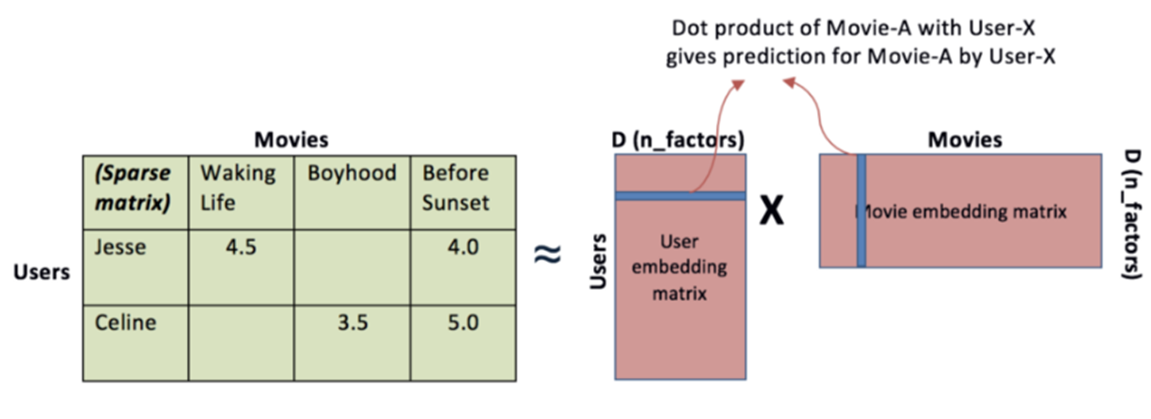

Matrix Factorisation works on the principle that we can learn the user and the item embeddings, and then predict the rating for each user-item by performing a dot (or scalar) product between the respective user and item embedding. 



In [31]:
# Applying matrix factorization: declare the output as being the dot product between the two embeddings: items and users
y = Dot(1, normalize=False)([user_vecs, item_vecs])





## Going deeper

Instead of taking a dot product of the user and the item embedding, concatenate or multiply them and use them as features for a neural network. 

Thus, we are not constrained to the dot product way of combining the embeddings, and can learn complex non-linear relationships.

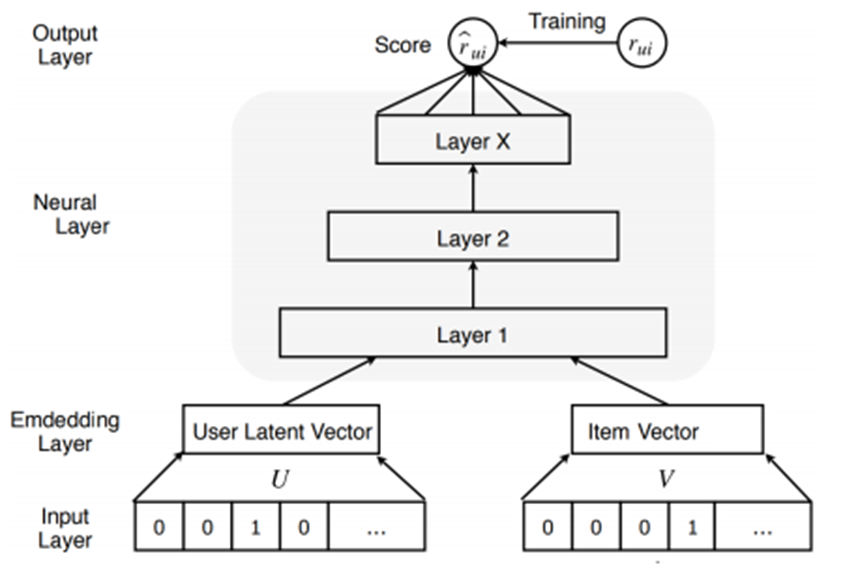






##### Check Performance

I searched around deep network architecture and checked:
- What happens if I add other layers on top of the first one? 
- What happens if I increase or decrease the embedding size? 
- What happens if I add dense layers on top of the embeddings before merging?
- What happens if I change the number of hidden units in each dense layer?
- What happens if I change the number of epochs?  
- What happens if I use Dropout or not?

Modifications are commented in the code below

###### Here is the model representation for deep neural network that can be compared to the Matrix Factorisation implementation:

In [32]:
# Try add dense layers on top of the embeddings before merging (Comment to drop this idea.)
user_vecs = Dense(64, activation='relu')(user_vecs) 
item_vecs = Dense(64, activation='relu')(item_vecs)
price_vecs = Dense(64, activation='relu')(price_vecs) 
title_vecs = Dense(64, activation='relu')(title_vecs)

In [33]:
# Concatenate the item embeddings :
item_vecs_complete  = Concatenate()([item_vecs, price_vecs,title_vecs])

# Concatenate user and item embeddings and use them as features for the neural network:
input_vecs = Concatenate()([user_vecs, item_vecs_complete]) # can be changed by Multiply
#input_vecs = Concatenate()([user_vecs, item_vecs]) # can be changed by Multiply

# Multiply user and item embeddings and use them as features for the neural network:
#input_vecs = Multiply()([user_vecs, item_vecs]) # can be changed by concat 

# Dropout is a technique where randomly selected neurons are ignored during training to prevent overfitting 
input_vecs = Dropout(0.1)(input_vecs)  

# Check one dense 128 or two dense layers (128,128) or (128,64) or three denses layers (128,64,32))

# First layer
# Dense(128) is a fully-connected layer with 128 hidden units.
# Use rectified linear units (ReLU) f(x)=max(0,x) as an activation function.
x = Dense(128, activation='relu')(input_vecs)
x = Dropout(0.1)(x) # Add droupout or not # To improve the performance

# Next Layers
#x = Dense(128, activation='relu')(x) # Add dense again or not 
x = Dense(64, activation='relu')(x) # Add dense again or not 
x = Dropout(0.1)(x) # Add droupout or not # To improve the performance
x = Dense(32, activation='relu')(x) # Add dense again or not #
x = Dropout(0.1)(x) # Add droupout or not # To improve the performance

# The output
y = Dense(1)(x)


###### declare a model that takes items and users as input and output y, our prediction.

In [34]:
model = Model(inputs=[user_id_input
                      , item_id_input
                      , price_id_input
                      , title_id_input
                     ], outputs=y)


###### compile the model with 'mse' loss, and "adam" loss optimization
I would optimise the model such that I minimise the mean squared error ('mse') on the ratings from the train set.
The Adam optimization algorithm used, is an extension to stochastic gradient

In [35]:
model.compile(loss='mse',  optimizer="adam" )

###### Save different histories and best models using keras ModelCheckpoint callback


In [36]:
save_path = "./models"
mytime = time.strftime("%Y_%m_%d_%H_%M")
modname = 'dense_2_15_embeddings_2_epochs' + mytime 
thename = save_path + '/' + modname + '.h5'
mcheck = ModelCheckpoint(thename  , monitor='val_loss', save_best_only=True)

###### Train the model by calling the model’s fit method

When training the model, the embeddings parameters are learnt too.

Use the internal keras random cross validation scheme (the validation_split=0.1 parameter below) instead of the test set to evaluate the models 

The test set will be kept to verify the quality of recommendations at the end.

In [37]:
history = model.fit([ratings_train["user_id"]
                    , ratings_train["item_id"]
                    , ratings_train["price_id"]
                    , ratings_train["title_id"]
                    ]
                    , ratings_train["score"]
                    , batch_size=64, epochs=2
                    , validation_split=0.1
                    , callbacks=[mcheck]
                    , shuffle=True)

Train on 1368242 samples, validate on 152027 samples
Epoch 1/1


  77120/1368242 [>.............................] - ETA: 27:51:39 - loss: 19.34 - ETA: 9:25:11 - loss: 19.9084 - ETA: 4:45:34 - loss: 19.998 - ETA: 2:53:33 - loss: 19.527 - ETA: 2:05:26 - loss: 19.341 - ETA: 1:38:44 - loss: 19.294 - ETA: 1:21:44 - loss: 18.932 - ETA: 1:09:58 - loss: 18.872 - ETA: 1:01:20 - loss: 18.718 - ETA: 54:44 - loss: 18.6669  - ETA: 49:32 - loss: 18.618 - ETA: 45:19 - loss: 18.581 - ETA: 41:50 - loss: 18.594 - ETA: 38:56 - loss: 18.563 - ETA: 36:26 - loss: 18.463 - ETA: 34:17 - loss: 18.317 - ETA: 32:25 - loss: 18.231 - ETA: 30:47 - loss: 18.156 - ETA: 28:55 - loss: 18.051 - ETA: 28:01 - loss: 17.984 - ETA: 26:51 - loss: 17.936 - ETA: 25:48 - loss: 17.855 - ETA: 24:50 - loss: 17.766 - ETA: 23:57 - loss: 17.700 - ETA: 23:10 - loss: 17.637 - ETA: 22:25 - loss: 17.568 - ETA: 21:45 - loss: 17.487 - ETA: 21:07 - loss: 17.385 - ETA: 20:33 - loss: 17.296 - ETA: 20:00 - loss: 17.167 - ETA: 19:30 - loss: 17.082 - ETA: 19:02 - loss: 16.969 - ETA: 18:36 - loss: 16.860 - ETA:

 391680/1368242 [=======>......................] - ETA: 4:27 - loss: 2.356 - ETA: 4:27 - loss: 2.355 - ETA: 4:27 - loss: 2.355 - ETA: 4:27 - loss: 2.354 - ETA: 4:27 - loss: 2.354 - ETA: 4:27 - loss: 2.353 - ETA: 4:27 - loss: 2.352 - ETA: 4:27 - loss: 2.351 - ETA: 4:27 - loss: 2.351 - ETA: 4:27 - loss: 2.350 - ETA: 4:26 - loss: 2.350 - ETA: 4:26 - loss: 2.349 - ETA: 4:26 - loss: 2.348 - ETA: 4:26 - loss: 2.348 - ETA: 4:26 - loss: 2.347 - ETA: 4:26 - loss: 2.347 - ETA: 4:26 - loss: 2.346 - ETA: 4:26 - loss: 2.345 - ETA: 4:26 - loss: 2.345 - ETA: 4:26 - loss: 2.344 - ETA: 4:26 - loss: 2.344 - ETA: 4:26 - loss: 2.343 - ETA: 4:26 - loss: 2.343 - ETA: 4:26 - loss: 2.342 - ETA: 4:26 - loss: 2.342 - ETA: 4:26 - loss: 2.342 - ETA: 4:25 - loss: 2.341 - ETA: 4:25 - loss: 2.340 - ETA: 4:25 - loss: 2.340 - ETA: 4:25 - loss: 2.339 - ETA: 4:25 - loss: 2.338 - ETA: 4:25 - loss: 2.338 - ETA: 4:25 - loss: 2.337 - ETA: 4:25 - loss: 2.336 - ETA: 4:25 - loss: 2.336 - ETA: 4:25 - loss: 2.335 - ETA: 4:25 - l

 470656/1368242 [=========>....................] - ETA: 4:04 - loss: 2.196 - ETA: 4:04 - loss: 2.195 - ETA: 4:04 - loss: 2.195 - ETA: 4:04 - loss: 2.195 - ETA: 4:04 - loss: 2.194 - ETA: 4:04 - loss: 2.194 - ETA: 4:04 - loss: 2.193 - ETA: 4:04 - loss: 2.193 - ETA: 4:04 - loss: 2.192 - ETA: 4:04 - loss: 2.192 - ETA: 4:04 - loss: 2.191 - ETA: 4:03 - loss: 2.191 - ETA: 4:03 - loss: 2.190 - ETA: 4:03 - loss: 2.190 - ETA: 4:03 - loss: 2.189 - ETA: 4:03 - loss: 2.189 - ETA: 4:03 - loss: 2.189 - ETA: 4:03 - loss: 2.188 - ETA: 4:03 - loss: 2.188 - ETA: 4:03 - loss: 2.187 - ETA: 4:03 - loss: 2.187 - ETA: 4:03 - loss: 2.186 - ETA: 4:03 - loss: 2.186 - ETA: 4:03 - loss: 2.185 - ETA: 4:03 - loss: 2.185 - ETA: 4:03 - loss: 2.184 - ETA: 4:03 - loss: 2.184 - ETA: 4:02 - loss: 2.183 - ETA: 4:02 - loss: 2.183 - ETA: 4:02 - loss: 2.183 - ETA: 4:02 - loss: 2.182 - ETA: 4:02 - loss: 2.182 - ETA: 4:02 - loss: 2.181 - ETA: 4:02 - loss: 2.181 - ETA: 4:02 - loss: 2.181 - ETA: 4:02 - loss: 2.180 - ETA: 4:02 - l

 541120/1368242 [==========>...................] - ETA: 3:43 - loss: 2.076 - ETA: 3:43 - loss: 2.076 - ETA: 3:42 - loss: 2.075 - ETA: 3:42 - loss: 2.075 - ETA: 3:42 - loss: 2.075 - ETA: 3:42 - loss: 2.074 - ETA: 3:42 - loss: 2.074 - ETA: 3:42 - loss: 2.074 - ETA: 3:42 - loss: 2.073 - ETA: 3:42 - loss: 2.073 - ETA: 3:42 - loss: 2.072 - ETA: 3:42 - loss: 2.072 - ETA: 3:42 - loss: 2.072 - ETA: 3:42 - loss: 2.072 - ETA: 3:42 - loss: 2.071 - ETA: 3:42 - loss: 2.071 - ETA: 3:42 - loss: 2.071 - ETA: 3:42 - loss: 2.070 - ETA: 3:41 - loss: 2.070 - ETA: 3:41 - loss: 2.070 - ETA: 3:41 - loss: 2.069 - ETA: 3:41 - loss: 2.069 - ETA: 3:41 - loss: 2.069 - ETA: 3:41 - loss: 2.068 - ETA: 3:41 - loss: 2.068 - ETA: 3:41 - loss: 2.068 - ETA: 3:41 - loss: 2.067 - ETA: 3:41 - loss: 2.067 - ETA: 3:41 - loss: 2.067 - ETA: 3:41 - loss: 2.066 - ETA: 3:41 - loss: 2.066 - ETA: 3:41 - loss: 2.066 - ETA: 3:41 - loss: 2.066 - ETA: 3:41 - loss: 2.065 - ETA: 3:40 - loss: 2.065 - ETA: 3:40 - loss: 2.065 - ETA: 3:40 - l

 618112/1368242 [============>.................] - ETA: 3:26 - loss: 1.992 - ETA: 3:26 - loss: 1.992 - ETA: 3:26 - loss: 1.992 - ETA: 3:26 - loss: 1.992 - ETA: 3:26 - loss: 1.991 - ETA: 3:26 - loss: 1.991 - ETA: 3:26 - loss: 1.991 - ETA: 3:26 - loss: 1.991 - ETA: 3:26 - loss: 1.990 - ETA: 3:26 - loss: 1.990 - ETA: 3:25 - loss: 1.990 - ETA: 3:25 - loss: 1.990 - ETA: 3:25 - loss: 1.990 - ETA: 3:25 - loss: 1.989 - ETA: 3:25 - loss: 1.989 - ETA: 3:25 - loss: 1.989 - ETA: 3:25 - loss: 1.989 - ETA: 3:25 - loss: 1.988 - ETA: 3:25 - loss: 1.988 - ETA: 3:25 - loss: 1.988 - ETA: 3:25 - loss: 1.988 - ETA: 3:25 - loss: 1.988 - ETA: 3:25 - loss: 1.987 - ETA: 3:25 - loss: 1.987 - ETA: 3:25 - loss: 1.987 - ETA: 3:25 - loss: 1.986 - ETA: 3:25 - loss: 1.986 - ETA: 3:24 - loss: 1.986 - ETA: 3:24 - loss: 1.986 - ETA: 3:24 - loss: 1.985 - ETA: 3:24 - loss: 1.985 - ETA: 3:24 - loss: 1.985 - ETA: 3:24 - loss: 1.984 - ETA: 3:24 - loss: 1.984 - ETA: 3:24 - loss: 1.984 - ETA: 3:24 - loss: 1.984 - ETA: 3:24 - l

 695744/1368242 [==============>...............] - ETA: 3:07 - loss: 1.919 - ETA: 3:07 - loss: 1.919 - ETA: 3:07 - loss: 1.919 - ETA: 3:07 - loss: 1.918 - ETA: 3:07 - loss: 1.918 - ETA: 3:06 - loss: 1.918 - ETA: 3:06 - loss: 1.918 - ETA: 3:06 - loss: 1.917 - ETA: 3:06 - loss: 1.917 - ETA: 3:06 - loss: 1.917 - ETA: 3:06 - loss: 1.917 - ETA: 3:06 - loss: 1.916 - ETA: 3:06 - loss: 1.916 - ETA: 3:06 - loss: 1.916 - ETA: 3:06 - loss: 1.916 - ETA: 3:06 - loss: 1.916 - ETA: 3:06 - loss: 1.915 - ETA: 3:06 - loss: 1.915 - ETA: 3:06 - loss: 1.915 - ETA: 3:06 - loss: 1.915 - ETA: 3:06 - loss: 1.915 - ETA: 3:05 - loss: 1.914 - ETA: 3:05 - loss: 1.914 - ETA: 3:05 - loss: 1.914 - ETA: 3:05 - loss: 1.914 - ETA: 3:05 - loss: 1.914 - ETA: 3:05 - loss: 1.914 - ETA: 3:05 - loss: 1.913 - ETA: 3:05 - loss: 1.913 - ETA: 3:05 - loss: 1.913 - ETA: 3:05 - loss: 1.913 - ETA: 3:05 - loss: 1.913 - ETA: 3:05 - loss: 1.912 - ETA: 3:05 - loss: 1.912 - ETA: 3:05 - loss: 1.912 - ETA: 3:05 - loss: 1.912 - ETA: 3:05 - l

 767744/1368242 [===============>..............] - ETA: 2:47 - loss: 1.859 - ETA: 2:47 - loss: 1.859 - ETA: 2:47 - loss: 1.859 - ETA: 2:47 - loss: 1.859 - ETA: 2:47 - loss: 1.859 - ETA: 2:47 - loss: 1.859 - ETA: 2:47 - loss: 1.858 - ETA: 2:47 - loss: 1.858 - ETA: 2:47 - loss: 1.858 - ETA: 2:47 - loss: 1.858 - ETA: 2:47 - loss: 1.857 - ETA: 2:47 - loss: 1.857 - ETA: 2:47 - loss: 1.857 - ETA: 2:47 - loss: 1.857 - ETA: 2:46 - loss: 1.857 - ETA: 2:46 - loss: 1.857 - ETA: 2:46 - loss: 1.856 - ETA: 2:46 - loss: 1.856 - ETA: 2:46 - loss: 1.856 - ETA: 2:46 - loss: 1.856 - ETA: 2:46 - loss: 1.856 - ETA: 2:46 - loss: 1.856 - ETA: 2:46 - loss: 1.855 - ETA: 2:46 - loss: 1.855 - ETA: 2:46 - loss: 1.855 - ETA: 2:46 - loss: 1.855 - ETA: 2:46 - loss: 1.855 - ETA: 2:46 - loss: 1.855 - ETA: 2:46 - loss: 1.854 - ETA: 2:46 - loss: 1.854 - ETA: 2:46 - loss: 1.854 - ETA: 2:46 - loss: 1.854 - ETA: 2:45 - loss: 1.854 - ETA: 2:45 - loss: 1.854 - ETA: 2:45 - loss: 1.853 - ETA: 2:45 - loss: 1.853 - ETA: 2:45 - l

 839168/1368242 [=================>............] - ETA: 2:30 - loss: 1.811 - ETA: 2:30 - loss: 1.810 - ETA: 2:30 - loss: 1.810 - ETA: 2:30 - loss: 1.810 - ETA: 2:29 - loss: 1.810 - ETA: 2:29 - loss: 1.810 - ETA: 2:29 - loss: 1.810 - ETA: 2:29 - loss: 1.810 - ETA: 2:29 - loss: 1.810 - ETA: 2:29 - loss: 1.809 - ETA: 2:29 - loss: 1.809 - ETA: 2:29 - loss: 1.809 - ETA: 2:29 - loss: 1.809 - ETA: 2:29 - loss: 1.809 - ETA: 2:29 - loss: 1.809 - ETA: 2:29 - loss: 1.808 - ETA: 2:29 - loss: 1.808 - ETA: 2:29 - loss: 1.808 - ETA: 2:29 - loss: 1.808 - ETA: 2:29 - loss: 1.808 - ETA: 2:29 - loss: 1.808 - ETA: 2:29 - loss: 1.808 - ETA: 2:29 - loss: 1.808 - ETA: 2:29 - loss: 1.807 - ETA: 2:28 - loss: 1.807 - ETA: 2:28 - loss: 1.807 - ETA: 2:28 - loss: 1.807 - ETA: 2:28 - loss: 1.807 - ETA: 2:28 - loss: 1.807 - ETA: 2:28 - loss: 1.807 - ETA: 2:28 - loss: 1.806 - ETA: 2:28 - loss: 1.806 - ETA: 2:28 - loss: 1.806 - ETA: 2:28 - loss: 1.806 - ETA: 2:28 - loss: 1.806 - ETA: 2:28 - loss: 1.806 - ETA: 2:28 - l

 912192/1368242 [===================>..........] - ETA: 2:12 - loss: 1.768 - ETA: 2:12 - loss: 1.768 - ETA: 2:12 - loss: 1.768 - ETA: 2:12 - loss: 1.768 - ETA: 2:12 - loss: 1.768 - ETA: 2:12 - loss: 1.768 - ETA: 2:12 - loss: 1.768 - ETA: 2:12 - loss: 1.768 - ETA: 2:12 - loss: 1.767 - ETA: 2:12 - loss: 1.767 - ETA: 2:11 - loss: 1.767 - ETA: 2:11 - loss: 1.767 - ETA: 2:11 - loss: 1.767 - ETA: 2:11 - loss: 1.767 - ETA: 2:11 - loss: 1.767 - ETA: 2:11 - loss: 1.766 - ETA: 2:11 - loss: 1.766 - ETA: 2:11 - loss: 1.766 - ETA: 2:11 - loss: 1.766 - ETA: 2:11 - loss: 1.766 - ETA: 2:11 - loss: 1.766 - ETA: 2:11 - loss: 1.766 - ETA: 2:11 - loss: 1.766 - ETA: 2:11 - loss: 1.765 - ETA: 2:11 - loss: 1.765 - ETA: 2:11 - loss: 1.765 - ETA: 2:11 - loss: 1.765 - ETA: 2:10 - loss: 1.765 - ETA: 2:10 - loss: 1.765 - ETA: 2:10 - loss: 1.765 - ETA: 2:10 - loss: 1.765 - ETA: 2:10 - loss: 1.764 - ETA: 2:10 - loss: 1.764 - ETA: 2:10 - loss: 1.764 - ETA: 2:10 - loss: 1.764 - ETA: 2:10 - loss: 1.764 - ETA: 2:10 - l

 982848/1368242 [====================>.........] - ETA: 1:54 - loss: 1.732 - ETA: 1:54 - loss: 1.732 - ETA: 1:54 - loss: 1.731 - ETA: 1:54 - loss: 1.731 - ETA: 1:54 - loss: 1.731 - ETA: 1:54 - loss: 1.731 - ETA: 1:54 - loss: 1.731 - ETA: 1:54 - loss: 1.731 - ETA: 1:53 - loss: 1.731 - ETA: 1:53 - loss: 1.731 - ETA: 1:53 - loss: 1.731 - ETA: 1:53 - loss: 1.731 - ETA: 1:53 - loss: 1.730 - ETA: 1:53 - loss: 1.730 - ETA: 1:53 - loss: 1.730 - ETA: 1:53 - loss: 1.730 - ETA: 1:53 - loss: 1.730 - ETA: 1:53 - loss: 1.730 - ETA: 1:53 - loss: 1.730 - ETA: 1:53 - loss: 1.730 - ETA: 1:53 - loss: 1.730 - ETA: 1:53 - loss: 1.729 - ETA: 1:53 - loss: 1.729 - ETA: 1:53 - loss: 1.729 - ETA: 1:53 - loss: 1.729 - ETA: 1:52 - loss: 1.729 - ETA: 1:52 - loss: 1.729 - ETA: 1:52 - loss: 1.729 - ETA: 1:52 - loss: 1.729 - ETA: 1:52 - loss: 1.729 - ETA: 1:52 - loss: 1.728 - ETA: 1:52 - loss: 1.728 - ETA: 1:52 - loss: 1.728 - ETA: 1:52 - loss: 1.728 - ETA: 1:52 - loss: 1.728 - ETA: 1:52 - loss: 1.728 - ETA: 1:52 - l

1055808/1368242 [======================>.......] - ETA: 1:36 - loss: 1.700 - ETA: 1:36 - loss: 1.699 - ETA: 1:36 - loss: 1.699 - ETA: 1:36 - loss: 1.699 - ETA: 1:36 - loss: 1.699 - ETA: 1:36 - loss: 1.699 - ETA: 1:36 - loss: 1.699 - ETA: 1:36 - loss: 1.699 - ETA: 1:36 - loss: 1.699 - ETA: 1:36 - loss: 1.699 - ETA: 1:36 - loss: 1.698 - ETA: 1:36 - loss: 1.698 - ETA: 1:36 - loss: 1.698 - ETA: 1:36 - loss: 1.698 - ETA: 1:36 - loss: 1.698 - ETA: 1:36 - loss: 1.698 - ETA: 1:35 - loss: 1.698 - ETA: 1:35 - loss: 1.698 - ETA: 1:35 - loss: 1.698 - ETA: 1:35 - loss: 1.698 - ETA: 1:35 - loss: 1.698 - ETA: 1:35 - loss: 1.698 - ETA: 1:35 - loss: 1.698 - ETA: 1:35 - loss: 1.698 - ETA: 1:35 - loss: 1.697 - ETA: 1:35 - loss: 1.697 - ETA: 1:35 - loss: 1.697 - ETA: 1:35 - loss: 1.697 - ETA: 1:35 - loss: 1.697 - ETA: 1:35 - loss: 1.697 - ETA: 1:35 - loss: 1.697 - ETA: 1:35 - loss: 1.697 - ETA: 1:35 - loss: 1.697 - ETA: 1:35 - loss: 1.697 - ETA: 1:35 - loss: 1.697 - ETA: 1:34 - loss: 1.697 - ETA: 1:34 - l

1127744/1368242 [=======================>......] - ETA: 1:18 - loss: 1.672 - ETA: 1:18 - loss: 1.672 - ETA: 1:18 - loss: 1.672 - ETA: 1:18 - loss: 1.672 - ETA: 1:18 - loss: 1.672 - ETA: 1:18 - loss: 1.671 - ETA: 1:18 - loss: 1.671 - ETA: 1:18 - loss: 1.671 - ETA: 1:18 - loss: 1.671 - ETA: 1:18 - loss: 1.671 - ETA: 1:17 - loss: 1.671 - ETA: 1:17 - loss: 1.671 - ETA: 1:17 - loss: 1.671 - ETA: 1:17 - loss: 1.671 - ETA: 1:17 - loss: 1.671 - ETA: 1:17 - loss: 1.671 - ETA: 1:17 - loss: 1.671 - ETA: 1:17 - loss: 1.671 - ETA: 1:17 - loss: 1.671 - ETA: 1:17 - loss: 1.670 - ETA: 1:17 - loss: 1.670 - ETA: 1:17 - loss: 1.670 - ETA: 1:17 - loss: 1.670 - ETA: 1:17 - loss: 1.670 - ETA: 1:17 - loss: 1.670 - ETA: 1:17 - loss: 1.670 - ETA: 1:17 - loss: 1.670 - ETA: 1:17 - loss: 1.670 - ETA: 1:16 - loss: 1.670 - ETA: 1:16 - loss: 1.670 - ETA: 1:16 - loss: 1.670 - ETA: 1:16 - loss: 1.670 - ETA: 1:16 - loss: 1.669 - ETA: 1:16 - loss: 1.669 - ETA: 1:16 - loss: 1.669 - ETA: 1:16 - loss: 1.669 - ETA: 1:16 - l

1206016/1368242 [=========================>....] - ETA: 1:00 - loss: 1.646 - ETA: 1:00 - loss: 1.646 - ETA: 1:00 - loss: 1.646 - ETA: 1:00 - loss: 1.646 - ETA: 1:00 - loss: 1.646 - ETA: 1:00 - loss: 1.646 - ETA: 1:00 - loss: 1.646 - ETA: 1:00 - loss: 1.646 - ETA: 1:00 - loss: 1.646 - ETA: 1:00 - loss: 1.646 - ETA: 1:00 - loss: 1.646 - ETA: 59s - loss: 1.646 - ETA: 59s - loss: 1.64 - ETA: 59s - loss: 1.64 - ETA: 59s - loss: 1.64 - ETA: 59s - loss: 1.64 - ETA: 59s - loss: 1.64 - ETA: 59s - loss: 1.64 - ETA: 59s - loss: 1.64 - ETA: 59s - loss: 1.64 - ETA: 59s - loss: 1.64 - ETA: 59s - loss: 1.64 - ETA: 59s - loss: 1.64 - ETA: 59s - loss: 1.64 - ETA: 59s - loss: 1.64 - ETA: 59s - loss: 1.64 - ETA: 59s - loss: 1.64 - ETA: 59s - loss: 1.64 - ETA: 59s - loss: 1.64 - ETA: 59s - loss: 1.64 - ETA: 58s - loss: 1.64 - ETA: 58s - loss: 1.64 - ETA: 58s - loss: 1.64 - ETA: 58s - loss: 1.64 - ETA: 58s - loss: 1.64 - ETA: 58s - loss: 1.64 - ETA: 58s - loss: 1.64 - ETA: 58s - loss: 1.64 - ETA: 58s - los

1280960/1368242 [===========================>..] - ETA: 40s - loss: 1.62 - ETA: 40s - loss: 1.62 - ETA: 40s - loss: 1.62 - ETA: 40s - loss: 1.62 - ETA: 40s - loss: 1.62 - ETA: 40s - loss: 1.62 - ETA: 40s - loss: 1.62 - ETA: 40s - loss: 1.62 - ETA: 40s - loss: 1.62 - ETA: 40s - loss: 1.62 - ETA: 40s - loss: 1.62 - ETA: 40s - loss: 1.62 - ETA: 40s - loss: 1.62 - ETA: 40s - loss: 1.62 - ETA: 40s - loss: 1.62 - ETA: 39s - loss: 1.62 - ETA: 39s - loss: 1.62 - ETA: 39s - loss: 1.62 - ETA: 39s - loss: 1.62 - ETA: 39s - loss: 1.62 - ETA: 39s - loss: 1.62 - ETA: 39s - loss: 1.62 - ETA: 39s - loss: 1.62 - ETA: 39s - loss: 1.62 - ETA: 39s - loss: 1.62 - ETA: 39s - loss: 1.62 - ETA: 39s - loss: 1.62 - ETA: 39s - loss: 1.62 - ETA: 39s - loss: 1.62 - ETA: 39s - loss: 1.62 - ETA: 39s - loss: 1.62 - ETA: 39s - loss: 1.62 - ETA: 38s - loss: 1.62 - ETA: 38s - loss: 1.61 - ETA: 38s - loss: 1.61 - ETA: 38s - loss: 1.61 - ETA: 38s - loss: 1.61 - ETA: 38s - loss: 1.61 - ETA: 38s - loss: 1.61 - ETA: 38s - lo

1356288/1368242 [============================>.] - ETA: 21s - loss: 1.60 - ETA: 21s - loss: 1.60 - ETA: 21s - loss: 1.60 - ETA: 21s - loss: 1.60 - ETA: 21s - loss: 1.60 - ETA: 21s - loss: 1.60 - ETA: 21s - loss: 1.60 - ETA: 21s - loss: 1.60 - ETA: 21s - loss: 1.60 - ETA: 21s - loss: 1.60 - ETA: 21s - loss: 1.60 - ETA: 21s - loss: 1.60 - ETA: 21s - loss: 1.60 - ETA: 21s - loss: 1.60 - ETA: 21s - loss: 1.60 - ETA: 21s - loss: 1.60 - ETA: 21s - loss: 1.60 - ETA: 21s - loss: 1.60 - ETA: 21s - loss: 1.60 - ETA: 20s - loss: 1.60 - ETA: 20s - loss: 1.60 - ETA: 20s - loss: 1.60 - ETA: 20s - loss: 1.60 - ETA: 20s - loss: 1.60 - ETA: 20s - loss: 1.60 - ETA: 20s - loss: 1.60 - ETA: 20s - loss: 1.60 - ETA: 20s - loss: 1.60 - ETA: 20s - loss: 1.60 - ETA: 20s - loss: 1.60 - ETA: 20s - loss: 1.60 - ETA: 20s - loss: 1.60 - ETA: 20s - loss: 1.60 - ETA: 20s - loss: 1.59 - ETA: 20s - loss: 1.59 - ETA: 20s - loss: 1.59 - ETA: 20s - loss: 1.59 - ETA: 19s - loss: 1.59 - ETA: 19s - loss: 1.59 - ETA: 19s - lo

1368242/1368242 [==============================] - ETA: 2s - loss: 1.582 - ETA: 2s - loss: 1.582 - ETA: 2s - loss: 1.582 - ETA: 2s - loss: 1.582 - ETA: 2s - loss: 1.582 - ETA: 2s - loss: 1.582 - ETA: 2s - loss: 1.582 - ETA: 2s - loss: 1.582 - ETA: 2s - loss: 1.582 - ETA: 2s - loss: 1.582 - ETA: 2s - loss: 1.582 - ETA: 2s - loss: 1.582 - ETA: 2s - loss: 1.582 - ETA: 2s - loss: 1.581 - ETA: 2s - loss: 1.581 - ETA: 2s - loss: 1.581 - ETA: 2s - loss: 1.581 - ETA: 1s - loss: 1.581 - ETA: 1s - loss: 1.581 - ETA: 1s - loss: 1.581 - ETA: 1s - loss: 1.581 - ETA: 1s - loss: 1.581 - ETA: 1s - loss: 1.581 - ETA: 1s - loss: 1.581 - ETA: 1s - loss: 1.581 - ETA: 1s - loss: 1.581 - ETA: 1s - loss: 1.581 - ETA: 1s - loss: 1.581 - ETA: 1s - loss: 1.581 - ETA: 1s - loss: 1.580 - ETA: 1s - loss: 1.580 - ETA: 1s - loss: 1.580 - ETA: 1s - loss: 1.580 - ETA: 1s - loss: 1.580 - ETA: 1s - loss: 1.580 - ETA: 1s - loss: 1.580 - ETA: 0s - loss: 1.580 - ETA: 0s - loss: 1.580 - ETA: 0s - loss: 1.580 - ETA: 0s - los

###### Save the fitted model history to a file

In [38]:
modname='dense_2_15_embeddings_2_epochs'  
with open('./histories/' + modname + '.pkl' , 'wb') as file_pi:  pickle.dump(history.history, file_pi)



## Compare the results of matrix factorization and different configurations of neural networks:


In [39]:
def disp_model(path,file,suffix):
    model = load_model(path+file+suffix)    
    ## Summarise the model 
    model.summary()    
    # Extract the learnt user and item embeddings, i.e., a table with number of items and users rows and columns, with number of columns is the dimension of the trained embedding.
    # In our case, the embeddings correspond exactly to the weights of the model:
    weights = model.get_weights()
    print ("embeddings \ weights shapes",[w.shape for w in weights])    
    return model
    
model_path = "./models/save/"

Running the model and looking at the corresponding history I get the following 
plots of the training  MSE loss for the different the embedding and epoches sizes :

In [40]:
def plt_pickle(path,file,suffix):
    with open(path+file+suffix , 'rb') as file_pi: 
        thepickle= pickle.load(file_pi)
        plot(thepickle["loss"],label ='Train Error ' + file,linestyle="--")
        plot(thepickle["val_loss"],label='Validation Error ' + file) 
        plt.legend()
        plt.xlabel("Epoch")
        plt.ylabel("Error")  
        ##plt.ylim(0, 0.1)
    return pd.DataFrame(thepickle,columns =['loss','val_loss'])

hist_path = "./histories/save/"

In [41]:
model=disp_model(model_path , 'matrix_facto_10_embeddings_3_epochs' , '.h5')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
item (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
user_embedding (Embedding)      (None, 1, 10)        1924030     user[0][0]                       
__________________________________________________________________________________________________
item_embedding (Embedding)      (None, 1, 10)        630010      item[0][0]                       
__________________________________________________________________________________________________
reshape_5 

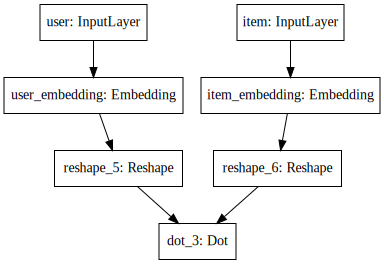

In [42]:
# Display the model using keras
SVG(model_to_dot(model).create(prog='dot', format='svg'))

,0,1,2
loss,1.866396e+06,2.581386e+06,3.648300e+06
val_loss,2.519401e+05,5.269719e+06,2.482086e+07


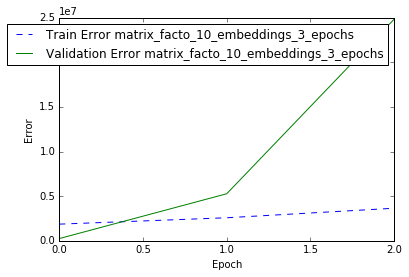

In [43]:
x=plt_pickle(hist_path , 'matrix_facto_10_embeddings_3_epochs' , '.pkl')
x.head(20).transpose()

###### Using matrix factorization with 10 embeddings and 3 epochs, the training and validation loss are very high and just go higher with each epoch, with no convergence.

In [44]:
model=disp_model(model_path , 'matrix_facto_10_embeddings_20_epochs' , '.h5')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
item (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
user_embedding (Embedding)      (None, 1, 10)        1924030     user[0][0]                       
__________________________________________________________________________________________________
item_embedding (Embedding)      (None, 1, 10)        630010      item[0][0]                       
__________________________________________________________________________________________________
reshape_19

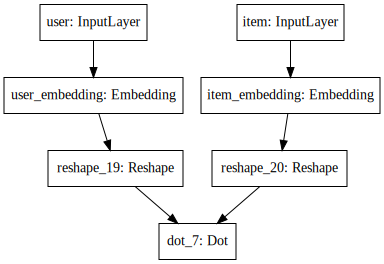

In [45]:
# Display the model using keras
SVG(model_to_dot(model).create(prog='dot', format='svg'))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
loss,479063.416201,1.122200e+06,4.252957e+08,4.212150e+08,3.064387e+10,3.178288e+10,3.191339e+10,3.198733e+10,3.587943e+10,1.881968e+12,1.837595e+14,1.836887e+14,1.836167e+14,1.855761e+14,1.856346e+14,1.861607e+14,1.860645e+14,1.859830e+14,1.865037e+14,1.868559e+14
val_loss,187.868871,1.953215e+07,8.601211e+09,9.965845e+09,1.130802e+10,2.595481e+10,2.593594e+11,2.599009e+11,2.564425e+11,3.475799e+19,3.475836e+19,3.475868e+19,3.475903e+19,3.476042e+19,3.476056e+19,3.476061e+19,3.476125e+19,3.476131e+19,3.476136e+19,3.476134e+19


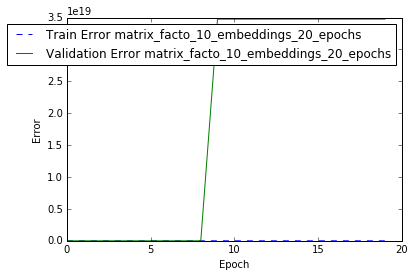

In [46]:
x=plt_pickle(hist_path , 'matrix_facto_10_embeddings_20_epochs' , '.pkl')
x.head(20).transpose()

In [47]:
#disp_model(model_path , 'matrix_facto_10_embeddings_100_epochs' , '.h5')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
loss,7.557159e+05,1.542805e+07,2.993318e+07,2.528199e+09,2.609957e+09,2.699140e+09,2.898956e+09,2.624575e+10,2.958747e+11,1.163360e+17,1.163311e+17,1.163262e+17,1.164620e+17,1.164572e+17,1.173266e+17,1.173206e+17,1.332755e+20,1.332758e+20,1.332757e+20,1.332756e+20
val_loss,1.116635e+06,6.164144e+06,6.840382e+09,1.914366e+10,1.931425e+11,1.943768e+11,1.997066e+11,2.887555e+11,2.911704e+11,3.558234e+11,3.613154e+11,3.743165e+11,4.454252e+13,1.642839e+14,6.613392e+14,6.982254e+14,7.791310e+14,8.193965e+14,2.380635e+15,2.423453e+15


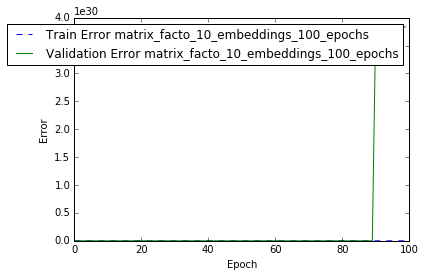

In [48]:
x=plt_pickle(hist_path , 'matrix_facto_10_embeddings_100_epochs' , '.pkl')
x.head(20).transpose()

###### Increasing number of epochs of matrix factorization to 20 or 100 does not help. Training and validation errors are still very high  and just go higher with each epoch, the model does not converge

###### Check the deep network results:


In [49]:
#model=disp_model(model_path , 'dense_2_Concatenate_10_embeddings_10_epochs' , '.h5')

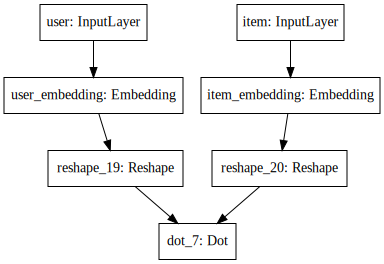

In [50]:
# Display the model using keras
SVG(model_to_dot(model).create(prog='dot', format='svg'))

,0,1,2,3,4,5,6,7,8,9
loss,1.382699,19.682429,5.070184,419.707727,101.452933,7.379136,1.305840,3.259892,1.681769,1.656726
val_loss,1.449930,1.509865,3.804780,542.079913,25.477693,1.449236,1.378446,1.417589,1.407691,1.419581


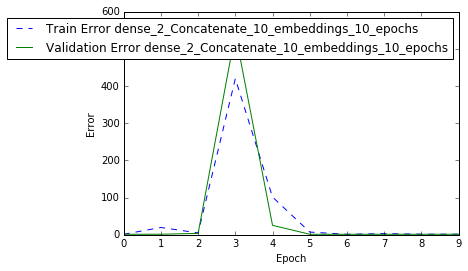

In [51]:
x=plt_pickle(hist_path , 'dense_2_Concatenate_10_embeddings_10_epochs' , '.pkl')
x.head(20).transpose()

###### Using 2 layers (each with 128 hidden units) neural network with 10 embeddings , Concatenate user and item embeddings , with Dropout and 10 epochs- the training error stabilises around 1.6 after 9 epochs and MSE validation error stabilises around 1.4 after 7 epochs. Lowest validation error is reached also after 7 epochs





In [52]:
model=disp_model(model_path , 'dense_3_Multiply_10_embeddings_100_epochs' , '.h5')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
item (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
user_embedding (Embedding)      (None, 1, 10)        1924030     user[0][0]                       
__________________________________________________________________________________________________
item_embedding (Embedding)      (None, 1, 10)        630010      item[0][0]                       
__________________________________________________________________________________________________
reshape_17

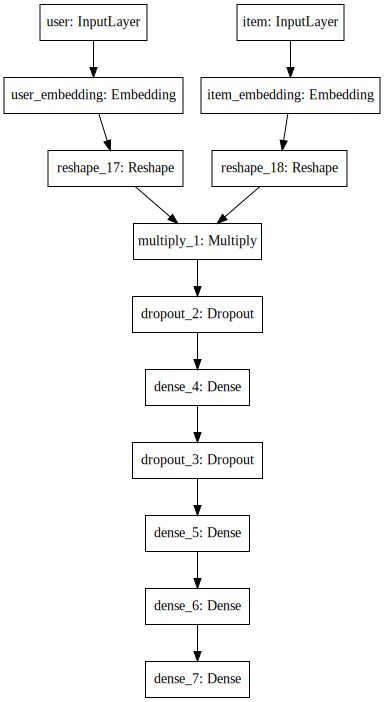

In [53]:
# Display the model using keras
SVG(model_to_dot(model).create(prog='dot', format='svg'))

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
loss,1.444964,1.403138,1.354679,1.926212,2.285215,1.335673,1.286848,1.251948,1.284106,1.268337,...,1.226110,1.262633,1.227035,1.223483,1.304088,1.231656,1.222677,1.222421,1.228102,1.221832
val_loss,1.403139,1.411150,1.432269,1.755252,7.952232,1.750958,1.475812,2.162102,1.437392,2.392615,...,1.600812,1.436061,1.495353,1.449071,1.439885,1.435341,1.434025,1.437449,1.434569,1.436615


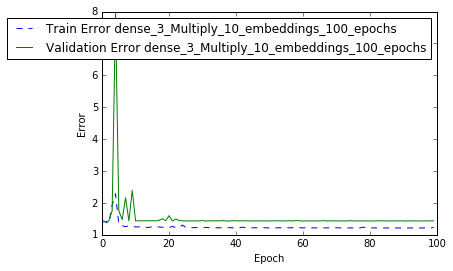

In [54]:
x=plt_pickle(hist_path , 'dense_3_Multiply_10_embeddings_100_epochs' , '.pkl')
x.head(30).transpose()

###### Using 3 layers (128,64,32) neural network with 10 embeddings, multiply user and item embeddings , with Dropout and 100 epochs, the training error stabilises around 1.2 after 7 epochs and MSE validation error stabilises around 1.4 after 7 epochs. Lowest validation error received only after 1 epoch. This is better than the above but not so good either.
###### The fact that training error is lower and and MSE validation error is about the same suggests overfitting



In [55]:
#model=disp_model(model_path , 'dense_2_Concatenate_20_embeddings_25_epochs' , '.h5')

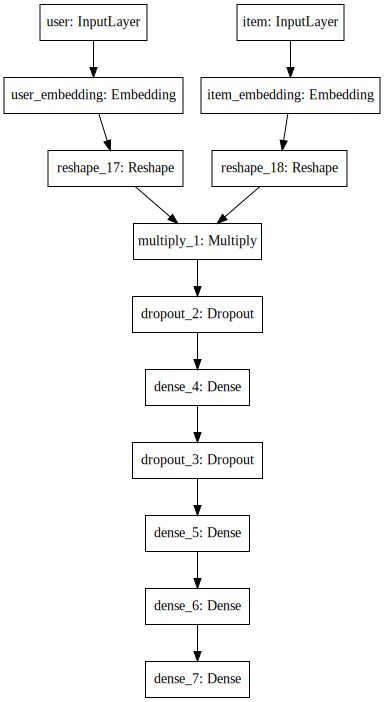

In [56]:
# Display the model using keras
SVG(model_to_dot(model).create(prog='dot', format='svg'))

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
loss,349.484213,61.442877,2.624867,1.633004,3.037708,3.926537,1.797485,2.145559,1.240334,1.280647,...,1.777545,1.388244,1.336034,1.010461,0.992358,2.101631,1.514952,1.277683,1.464251,1.598771
val_loss,326.233384,2.352207,1.345478,1.332989,1.523234,1.697809,1.393781,1.382120,1.449964,1.427573,...,1.438808,1.434964,1.428418,1.421310,1.538707,1.440140,1.699042,1.439657,1.430445,1.437529


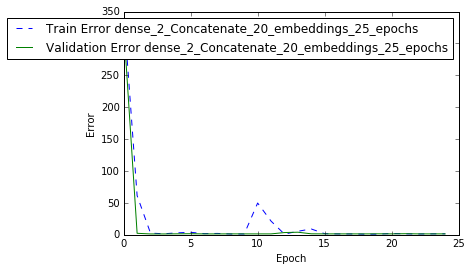

In [57]:
x=plt_pickle(hist_path , 'dense_2_Concatenate_20_embeddings_25_epochs' , '.pkl')
x.head(30).transpose()

###### Using 2 layers (128,64) neural network with 20 embeddings, Concatenate user and item embeddings , with Dropout and 25 epochs, MSE validation error stabilises again around 1.4 after 7 epochs. 
###### No improuvment



In [58]:
#model=disp_model(model_path , 'dense_4_Multiply_5_embeddings_7_epochs' , '.h5')

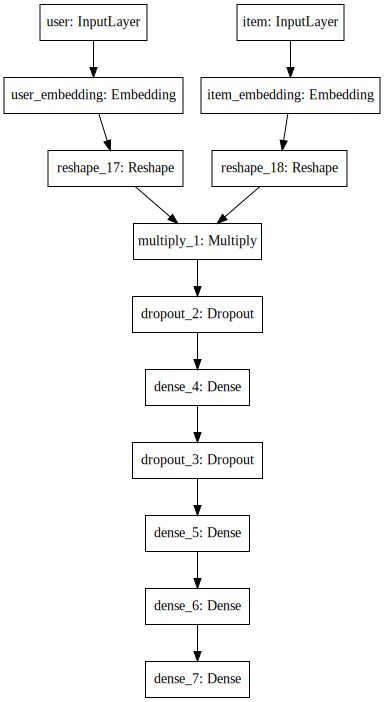

In [59]:
# Display the model using keras
SVG(model_to_dot(model).create(prog='dot', format='svg'))

,0,1,2,3,4,5,6
loss,1.438933,1.396619,1.321142,1.274875,1.253255,1.241958,1.234709
val_loss,1.405386,1.421863,1.452566,1.473197,1.482325,1.470126,1.480080


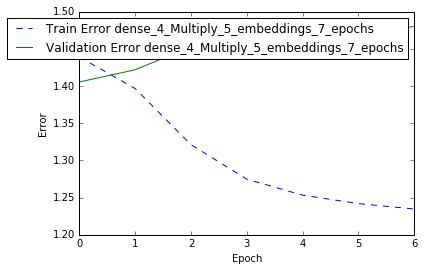

In [60]:
x=plt_pickle(hist_path , 'dense_4_Multiply_5_embeddings_7_epochs' , '.pkl')
x.head(30).transpose()

###### Using 4 layers (128,128,64,32) neural network with 5 embeddings, Multiply user and item embeddings , with no Dropout and 7 epochs, the training error is getting down and MSE validation error getting up after 2 epochs. Lowest validation error 1.4 is reached only after 2 epochs
###### The system is overfitting quickly

Check only one epoch with high number of embeddings

In [61]:
#model=disp_model(model_path , 'dense_1_Multiply_50_embeddings_7_epochs' , '.h5')

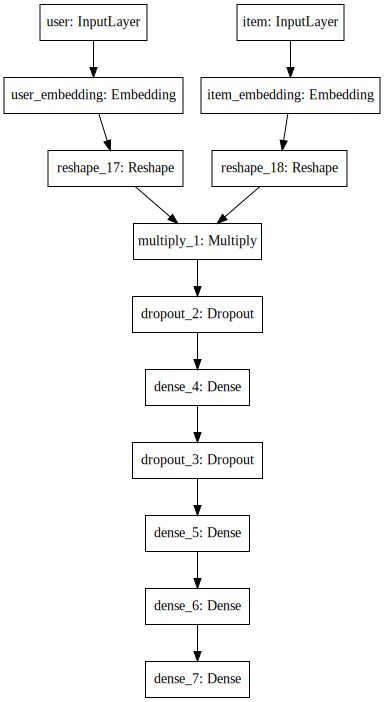

In [62]:
# Display the model using keras
SVG(model_to_dot(model).create(prog='dot', format='svg'))

,0,1,2,3,4,5,6
loss,1.489994,1.310061,1.254910,1.227841,1.223147,1.217684,1.214365
val_loss,1.408910,1.440152,1.439607,1.453188,1.431191,1.444831,1.446077


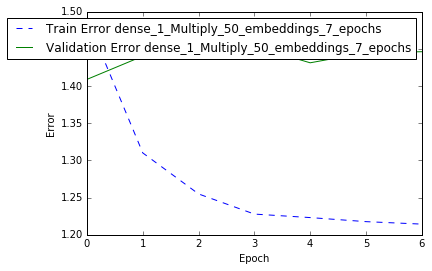

In [63]:
x=plt_pickle(hist_path , 'dense_1_Multiply_50_embeddings_7_epochs' , '.pkl')
x.head(30).transpose()

###### Using 1 layer (128) network with 50 embeddings, Multiply user and item embeddings , with no Dropout and 7 epochs, the training error is getting down and MSE validation error getting up after 2 epochs. Lowest validation error is still 1.4 and  reached only after 1 epochs
###### The system is overfitting quickly with no improuvment

##### Concatenating user and item embeddings, with embedding size of 15,  2 layers and 5 epochs
      

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
item (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
user_embedding (Embedding)      (None, 1, 15)        2886045     user[0][0]                       
__________________________________________________________________________________________________
item_embedding (Embedding)      (None, 1, 15)        945015      item[0][0]                       
__________________________________________________________________________________________________
reshape_1 

,0,1,2,3,4
loss,1.386442,1.190810,1.131412,1.097353,1.070782
val_loss,1.299618,1.287841,1.294824,1.311352,1.325501


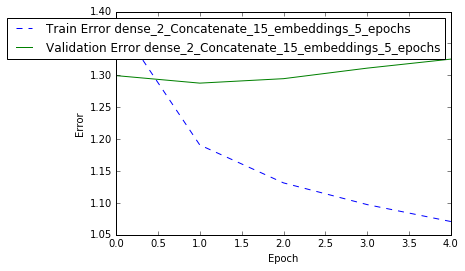

In [64]:
model=disp_model(model_path , 'dense_2_Concatenate_15_embeddings_5_epochs' , '.h5')
#Display the model using keras
SVG(model_to_dot(model).create(prog='dot', format='svg'))
x=plt_pickle(hist_path , 'dense_2_Concatenate_15_embeddings_5_epochs' , '.pkl')
x.head(30).transpose()

###### Concatenating user and item embeddings, with embedding size of 15, 2 layers , with Dropouts and 5 epochs, the training error is getting down and MSE validation error getting up after 2 epochs. Lowest validation error of 1.29 is reached only after 2 epochs. This is a little better



###### Adding metadata with 15 embeddings,  dense layers on top of the embeddings before merging , with Dropouts and 5 epochs:

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
item (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
user_embedding (Embedding)      (None, 1, 15)        2886045     user[0][0]                       
__________________________________________________________________________________________________
item_embedding (Embedding)      (None, 1, 15)        945015      item[0][0]                       
__________________________________________________________________________________________________
reshape_13

,0,1,2,3,4
loss,1.424921,1.200587,1.122776,1.087344,1.069624
val_loss,1.308717,1.288443,1.302459,1.294941,1.307511


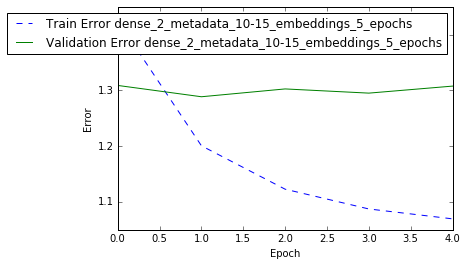

In [65]:
#Display the model using keras
model=disp_model(model_path , 'dense_2_metadata_10-15_embeddings_5_epochs' , '.h5')
SVG(model_to_dot(model).create(prog='dot', format='svg'))
x=plt_pickle(hist_path , 'dense_2_metadata_10-15_embeddings_5_epochs' , '.pkl')
x.head(30).transpose()

###### Using 2 layers, adding metadata with 15 embeddings, dense layers on top of the embeddings before concatenating, with Dropout and 5 epochs, the MSE validation error stabilises around 1.28 after 2 epochs

###### Adding metadata with 20 embeddings,  dense layers on top of the embeddings before merging , with Dropouts and 4 epochs:

,0,1,2,3
loss,1.335478,1.09737,1.014028,0.949043
val_loss,1.214296,1.19808,1.206000,1.245808


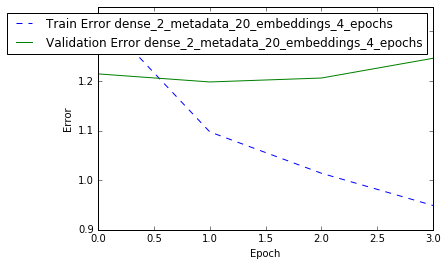

In [66]:
#Display the model using keras
#model=disp_model(model_path , 'dense_2_metadata_20_embeddings_4_epochs' , '.h5')
SVG(model_to_dot(model).create(prog='dot', format='svg'))
x=plt_pickle(hist_path , 'dense_2_metadata_20_embeddings_4_epochs' , '.pkl')
x.head(30).transpose()  

##### Adding metadata with 20 embeddings,  dense layers on top of the embeddings before concatenating , with Dropouts and 4 epochs, the training error is getting down and MSE validation error getting up after less than 2 epochs. Lowest validation error is reached only after 2 epochs, and it is the lowest so far


###### Adding metadata with 50 embeddings,   dense layers on top of the embeddings before merging , with Dropouts and 3 epochs:

,0,1,2
loss,1.366035,1.089463,0.990265
val_loss,1.216292,1.195979,1.230278


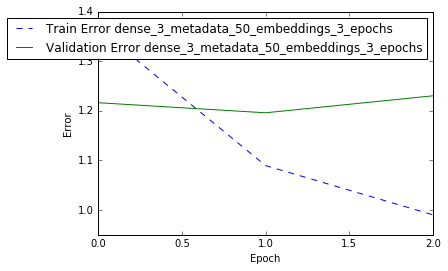

In [67]:
#Display the model using keras
SVG(model_to_dot(model).create(prog='dot', format='svg'))
x=plt_pickle(hist_path , 'dense_3_metadata_50_embeddings_3_epochs' , '.pkl')
x.head(30).transpose()  

###### Using 3 layers (128,64,32), adding metadata with 50 embeddings, dense layers on top of the embeddings before concatenating, with Dropout and 3 epochs, the MSE validation error stabilises around 1.195 after 2 epochs. 
###### This is the best result I could reach

##### We can notice the following points from the above:

- Performance got way better when using neural network comparing to using matrix factorization.

- When using neural network, I converge to the best model very quickly, sometimes after 2 epochs and after that the model starts overfitting or at least the validation error does not seem to go down anymore. Matrix factorization does not converge at all.

- Adding epochs lead to overfitting

- Adding layers (over 3) does not help much and actually leads to overfitting

- Changing the number of hidden units does not help.

- Simplifying the model by reducing embedding size does not help either.

- Choosing large values of embedding has made a small improvement in the results.

- Multiply or concatenate user and item embeddings does not seem to matter, but concatenate seems to give little better results

- Training with Dropout seem to prevent some overfitting

- Adding dense layers on top of the embeddings before the merge helps a bit.

- Adding some metadata lead to some improvement in the results.

- Running on a larger dataset does not help either, because the data in both datasets is very skewed.


## Evaluate and compare the different models
Using the 10% of cross validated training set records  and the history I saved:

In [69]:
hist_path = "./histories/save/"
validation_error = {}
train_error = {}
models =[
                 'matrix_facto_10_embeddings_20_epochs'
                ,'matrix_facto_10_embeddings_3_epochs'
                ,'matrix_facto_10_embeddings_100_epochs'
                ,'dense_1_Concatenate_1_embeddings_1_epochs'
                ,'dense_4_Multiply_5_embeddings_7_epochs' 
                ,'dense_3_Multiply_10_embeddings_100_epochs'
                ,'dense_2_Concatenate_20_embeddings_25_epochs'
                ,'dense_2_Concatenate_10_embeddings_10_epochs'
                ,'dense_1_Multiply_50_embeddings_7_epochs' 
                ,'dense_2_Concatenate_10_embeddings_1_epochs'
                ,'dense_2_Concatenate_15_embeddings_5_epochs' 
                ,'dense_2_metadata_10-15_embeddings_5_epochs'
                ,'dense_2_metadata_20_embeddings_4_epochs'
                ,'dense_3_metadata_50_embeddings_3_epochs'
        ]
for val in models:
    with open(hist_path +  val +'.pkl', 'rb') as file_pi:
        thepickle = pickle.load(file_pi)
        
        validation_error[val]=np.min(thepickle["val_loss"])
        train_error[val]=np.min(thepickle["loss"])
        
validation_error = pd.Series(validation_error)
train_error = pd.Series(train_error)
print ("MSE validation error \n",validation_error.sort_values(ascending=True).head(20))
print ("\nTrain error \n",train_error.sort_values(ascending=True).head(20))


MSE validation error 
 dense_3_metadata_50_embeddings_3_epochs        1.195979e+00
dense_2_metadata_20_embeddings_4_epochs        1.198080e+00
dense_2_Concatenate_15_embeddings_5_epochs     1.287841e+00
dense_2_metadata_10-15_embeddings_5_epochs     1.288443e+00
dense_2_Concatenate_10_embeddings_1_epochs     1.304706e+00
dense_1_Concatenate_1_embeddings_1_epochs      1.310986e+00
dense_2_Concatenate_20_embeddings_25_epochs    1.332989e+00
dense_2_Concatenate_10_embeddings_10_epochs    1.378446e+00
dense_3_Multiply_10_embeddings_100_epochs      1.403139e+00
dense_4_Multiply_5_embeddings_7_epochs         1.405386e+00
dense_1_Multiply_50_embeddings_7_epochs        1.408910e+00
matrix_facto_10_embeddings_20_epochs           1.878689e+02
matrix_facto_10_embeddings_3_epochs            2.519401e+05
matrix_facto_10_embeddings_100_epochs          1.116635e+06
dtype: float64

Train error 
 dense_2_metadata_20_embeddings_4_epochs        9.490434e-01
dense_3_metadata_50_embeddings_3_epochs        

###### Real test results

## Predict - Verifying the performance on the test set.
Check whether our results are reproducible on unseen data.

Test on new data using previously saved models.

I got the following results on the test set:


In [138]:
load_path = "./models/save/"
perfs = {}
models =[
                 'matrix_facto_10_embeddings_20_epochs'
                ,'matrix_facto_10_embeddings_3_epochs'
                ,'dense_1_Concatenate_1_embeddings_1_epochs'
                ,'dense_4_Multiply_5_embeddings_7_epochs' 
                ,'dense_3_Multiply_10_embeddings_100_epochs'
                ,'dense_2_Concatenate_20_embeddings_25_epochs'
                ,'dense_2_Concatenate_10_embeddings_10_epochs'
                ,'dense_1_Multiply_50_embeddings_7_epochs'
                ,'dense_2_Concatenate_10_embeddings_1_epochs'  
                ,'dense_2_Concatenate_15_embeddings_5_epochs'    
                ,'dense_2_metadata_10-15_embeddings_5_epochs'  
        ]

for mod in models:
    model = load_model(load_path+mod+'.h5')
    ratings_test['preds_' + mod] = model.predict([ratings_test['user_id'],ratings_test['item_id']])
    perfs[mod] = mean_squared_error(ratings_test['score'], ratings_test['preds_'+mod])

perfs= pd.Series(perfs)
perfs.sort_values(ascending=True).head(20)

dense_2_Concatenate_15_embeddings_5_epochs          1.291804
dense_2_metadata_10-15_embeddings_5_epochs          1.291974
dense_2_Concatenate_10_embeddings_1_epochs          1.307833
dense_1_Concatenate_1_embeddings_1_epochs           1.314382
dense_2_Concatenate_20_embeddings_25_epochs         1.337657
dense_2_Concatenate_10_embeddings_10_epochs         1.384906
dense_3_Multiply_10_embeddings_100_epochs           1.405945
dense_4_Multiply_5_embeddings_7_epochs              1.407891
dense_1_Multiply_50_embeddings_7_epochs             1.411244
matrix_facto_10_embeddings_3_epochs                55.880400
matrix_facto_10_embeddings_20_epochs           138707.923046
dtype: float64

In [72]:
load_path = "./models/save/"
#reset_keras()
perfs = {}
models =[
               'dense_2_metadata_20_embeddings_4_epochs'
               , 'dense_3_metadata_50_embeddings_3_epochs'    
        ]

for mod in models:
    model = load_model(load_path+mod+'.h5')
    ratings_test['preds_' + mod] = model.predict([ratings_test["user_id"]
                                                , ratings_test["item_id"]
                                                , ratings_test["price_id"]
                                                , ratings_test["title_id"]
                                                ])
    
    perfs[mod] = mean_squared_error(ratings_test['score'], ratings_test['preds_'+mod]) ## MSE between real score and prdicted score

perfs= pd.Series(perfs)
#perfs.sort()
perfs


dense_2_metadata_20_embeddings_4_epochs    1.420002
dense_3_metadata_50_embeddings_3_epochs    1.455593
dtype: float64

###### MSE on test data is very similar to what I got on the evaluation data
###### The best result  on both the internal keras random cross validation scheme and test-set acheived when using 2 layers, 15 layered concatenated embeddings, Dropout and 5 epochs
###### I will use this model further for executing recommendations (dense_2_Concatenate_15_embeddings_5_epochs )

# Recommend:
The last thing to do is to use our saved models to recommend items to users:



For the requested user:
- Calculate the score for every item.
- Sort the items based on the score and output the top results.


###### Check which users exist on the test set

In [68]:
ratings_test.user_id.value_counts().sort_values(ascending=False).head(10)

5501     50
5151     42
1246     40
5616     37
2601     36
11423    33
5109     31
391      30
1103     30
3276     29
Name: user_id, dtype: int64

###### Create a  recommendation example dataset of 100 users from the test set and 100 random items for each and predict recommendations for them

In [69]:
items = all_info.item_id.unique()
df_items = pd.DataFrame(data=items.flatten(),columns=['item_id'])
df_items = pd.merge(df_items,all_info,how='left',left_on=('item_id'),right_on=('item_id'))
df_items= df_items.sample(100)
df_items['key'] = 1
print ("We have %d unique items  "%df_items['item_id'].shape[0])
df_items= df_items[['item_id', 'description', 'categories', 'title', 'price', 'brand', 'key']]
df_items.head(2)

We have 100 unique items  


,item_id,description,categories,title,price,brand,key
379944,379944,"8 GB 240 Pin 667Mhz PC-5300 (2 x 4 GB)Made from the highest quality components, Arch Memory part...","[[Electronics, Computers & Accessories, Computer Components, Memory]]",8GB Memory RAM Kit (2 x 4 GB) for Dell Poweredge 2950 2U Rack Server by Arch Memory,195.95,NaN,1
129835,129835,"Patriot memory cards combine massive storage capacity, blazing data transfer rates and ironclad ...","[[Electronics, Computers & Accessories, Cables & Accessories, Memory Cards, Micro SD Cards]]",NEW 8Gb Genuine Patriot Memory Card for BLACKBERRY CURVE 8900 Cell Phone,29.33,Patriot,1


In [70]:
users = ratings_test.user_id.unique()
df_users = pd.DataFrame(data=users.flatten(),columns=['user_id'])
df_users = pd.merge(df_users,ratings_test,how='left',left_on=('user_id'),right_on=('user_id'))
df_users= df_users.sample(100)
df_users['key'] = 1
print ("We have %d unique users  "%df_users['user_id'].shape[0])
df_users= df_users[['user_id', 'user_name', 'key']]
df_users.head(2)

We have 100 unique users  


,user_id,user_name,key
125581,28625,W. TIMMONS,1
148612,96683,"Amazon Customer ""msjeannie""",1


###### Merge users and item and items metadata

In [71]:
df_unseenData= pd.merge(df_users, df_items, on='key')
del df_unseenData['key']
print ("We have %d unique records in the recommendation example dataset "%df_unseenData.shape[0])
df_unseenData.head(2)

We have 10000 unique records in the recommendation example dataset 


,user_id,user_name,item_id,description,categories,title,price,brand
0,28625,W. TIMMONS,379944,"8 GB 240 Pin 667Mhz PC-5300 (2 x 4 GB)Made from the highest quality components, Arch Memory part...","[[Electronics, Computers & Accessories, Computer Components, Memory]]",8GB Memory RAM Kit (2 x 4 GB) for Dell Poweredge 2950 2U Rack Server by Arch Memory,195.95,NaN
1,28625,W. TIMMONS,129835,"Patriot memory cards combine massive storage capacity, blazing data transfer rates and ironclad ...","[[Electronics, Computers & Accessories, Cables & Accessories, Memory Cards, Micro SD Cards]]",NEW 8Gb Genuine Patriot Memory Card for BLACKBERRY CURVE 8900 Cell Phone,29.33,Patriot


###### Predict the ratings for the items and users in the a recommendation example dataset:

In [73]:
load_path = "./models/save/"
models =[
                 'matrix_facto_10_embeddings_20_epochs'
                ,'matrix_facto_10_embeddings_3_epochs'
                ,'dense_1_Concatenate_1_embeddings_1_epochs'
                ,'dense_4_Multiply_5_embeddings_7_epochs' 
                ,'dense_3_Multiply_10_embeddings_100_epochs'
                ,'dense_2_Concatenate_20_embeddings_25_epochs'
                ,'dense_2_Concatenate_10_embeddings_10_epochs'
                ,'dense_1_Multiply_50_embeddings_7_epochs'
                ,'dense_2_Concatenate_10_embeddings_1_epochs'  
                ,'dense_2_Concatenate_15_embeddings_5_epochs'    
                ,'dense_2_metadata_10-15_embeddings_5_epochs'  
        ]

for mod in models:
    model = load_model(load_path+mod+'.h5')
    df_unseenData['preds_' + mod] = model.predict([df_unseenData['user_id'],df_unseenData['item_id']])
    
df_unseenData.head(2)

,user_id,user_name,item_id,description,categories,title,price,brand,preds_matrix_facto_10_embeddings_20_epochs,preds_matrix_facto_10_embeddings_3_epochs,preds_dense_1_Concatenate_1_embeddings_1_epochs,preds_dense_4_Multiply_5_embeddings_7_epochs,preds_dense_3_Multiply_10_embeddings_100_epochs,preds_dense_2_Concatenate_20_embeddings_25_epochs,preds_dense_2_Concatenate_10_embeddings_10_epochs,preds_dense_1_Multiply_50_embeddings_7_epochs,preds_dense_2_Concatenate_10_embeddings_1_epochs,preds_dense_2_Concatenate_15_embeddings_5_epochs,preds_dense_2_metadata_10-15_embeddings_5_epochs
0,28625,W. TIMMONS,379944,"8 GB 240 Pin 667Mhz PC-5300 (2 x 4 GB)Made from the highest quality components, Arch Memory part...","[[Electronics, Computers & Accessories, Computer Components, Memory]]",8GB Memory RAM Kit (2 x 4 GB) for Dell Poweredge 2950 2U Rack Server by Arch Memory,195.95,NaN,0.0,0.0,4.396528,4.191014,4.223793,4.726104,4.599386,4.157639,4.362162,4.559717,4.531211
1,28625,W. TIMMONS,129835,"Patriot memory cards combine massive storage capacity, blazing data transfer rates and ironclad ...","[[Electronics, Computers & Accessories, Cables & Accessories, Memory Cards, Micro SD Cards]]",NEW 8Gb Genuine Patriot Memory Card for BLACKBERRY CURVE 8900 Cell Phone,29.33,Patriot,0.0,0.0,4.396528,4.191014,4.223793,4.726104,4.599386,4.157639,4.362162,4.559717,4.531211


Check which users exist on the example set

In [182]:
df_unseenData.user_id.value_counts().sort_values(ascending=False).head(5)
df_unseenData[['user_id','preds_dense_2_Concatenate_15_embeddings_5_epochs']].sort_values('preds_dense_2_Concatenate_15_embeddings_5_epochs',ascending=True).head(5)

,user_id,preds_dense_2_Concatenate_15_embeddings_5_epochs
520,75833,2.758401
8120,128296,2.800730
4820,78658,2.856994
320,160495,2.979770
2620,10436,2.991529


###### A function that will return recommendation list for a given user

In [135]:
load_path = "./models/save/"
def get_recommendations(userID , model_scr, df_Data):
    if userID not in df_Data['user_id'].values:
        print("\nUser ID not found %d" %userID)
        return userID
       
    print("\nRecommendations for user id %d Name: %s is:" % (userID, df_Data.loc[df_Data['user_id'] == userID, 'user_name'].values[0]))
   
    df_output=df_Data.loc[df_Data['user_id'] == userID][['item_id','title','description','categories','price','preds_' + model_scr,    
     ]].sort_values('preds_' + model_scr,ascending=False).set_index('item_id')
    
    df_output.rename(columns={'preds_' + model_scr: 'score'}, inplace=True)
    return df_output

### Recommend items to a given user

In [200]:
#######  62533	48310                       
df_output = get_recommendations(userID=62533 ,model_scr='dense_2_Concatenate_15_embeddings_5_epochs',df_Data=df_unseenData)
df_output.head(10)


Recommendations for user id 62533 Name: BubbleCat is:


,title,description,categories,price,score
item_id,,,,,
30866,3 FT Digital Audio Optical TOSLink Cable Optic 3ft,Optical cable interconnects for A/V equipment with digital input and output jacks. Using the dig...,"[[Electronics, Accessories & Supplies, Audio & Video Accessories, Cables & Interconnects, Audio ...",1.78,4.867410
46171,Omnimount Wishbone Universal Combo Platinum Plasma TV Wall Mount,The CL-X offers a dual-arm configuration with a dual-stud mounting bracket for added strength an...,"[[Electronics, Accessories & Supplies, Audio & Video Accessories, TV Accessories & Parts, TV Cei...",24.99,4.769861
37567,"BoxWave Amazon Kindle Paperwhite 10W Wall Charger Direct - 5V, 2A Fast Micro USB Wall Charger Ki...",BoxWave'sWall Charger Directis a travel charger that will safely rapid charge your Amazon Kindle...,"[[Electronics, Computers & Accessories, Laptop & Netbook Computer Accessories, Chargers & Adapte...",8.95,4.768617
5162,Tiffen 58mm Haze-1 Filter,Eliminates UV problems from most situations where increased haze tends to wash out color and im...,"[[Electronics, Camera & Photo, Accessories, Filters & Accessories, Skylight & UV Filters]]",9.99,4.749544
9290,Sony VCLHG2037X High Grade Telephoto Lens for some Sony Camcorders,Extend your camcorder recording capabilities with a Wide Angle Lens from Sony. It broadens the p...,"[[Electronics, Camera & Photo, Lenses, Camera Lenses, Digital Camera Lenses]]",19.99,4.711574
35566,VanDyke P/S RECEPT MNT 24VDC-300MA UNFILT ( VP-324 ) (Discontinued by Manufacturer),"- Valcom linear power supply- Receptacle mount- 24 vdc 250 mA- Unfiltered ""B"" battery power supp...","[[Electronics, Accessories & Supplies, Batteries, Chargers & Accessories, AC Adapters]]",19.84,4.707929
23908,Power Supply For Heavy Duty Camera Housing with Heated Blower,Power Supply for Heavy-Duty Camera Housing with Heater / Blower,"[[Electronics, Security & Surveillance, Accessories, Surveillance Housing & Mounting Brackets]]",14.42,4.707219
37972,APC Replacement BF500 UPS battery [Electronics],APC Replacement BF500 UPS battery [Electronics],"[[Electronics, Computers & Accessories, Cables & Accessories, Uninterrupted Power Supply (UPS)]]",32.93,4.700919
379944,8GB Memory RAM Kit (2 x 4 GB) for Dell Poweredge 2950 2U Rack Server by Arch Memory,"8 GB 240 Pin 667Mhz PC-5300 (2 x 4 GB)Made from the highest quality components, Arch Memory part...","[[Electronics, Computers & Accessories, Computer Components, Memory]]",195.95,4.700650


##### Make predictions for another user using another model:

In [201]:
#######  20818	14398	79321
df_output = get_recommendations(userID=20818 ,model_scr='dense_3_Multiply_10_embeddings_100_epochs',df_Data=df_unseenData)
df_output.head(10)


Recommendations for user id 20818 Name: Amazon Customer "geekacres" is:


,title,description,categories,price,score
item_id,,,,,
1793,Energizer NH22BP ACCU 9-Volt Rechargeable Battery,Energizer Rechargeable NiMH round cell batteries' leading-edge technology makes them ideal for t...,"[[Electronics, Camera & Photo, Accessories, Batteries & Chargers, Batteries, Camera Batteries]]",9.49,4.228339
37972,APC Replacement BF500 UPS battery [Electronics],APC Replacement BF500 UPS battery [Electronics],"[[Electronics, Computers & Accessories, Cables & Accessories, Uninterrupted Power Supply (UPS)]]",32.93,4.224674
30866,3 FT Digital Audio Optical TOSLink Cable Optic 3ft,Optical cable interconnects for A/V equipment with digital input and output jacks. Using the dig...,"[[Electronics, Accessories & Supplies, Audio & Video Accessories, Cables & Interconnects, Audio ...",1.78,4.224575
47497,"Plastic Filter Guard And Retainer, 60mm","Plastic Filter Guard And Retainer, 60mm","[[Electronics, Computers & Accessories, Computer Components, Fans & Cooling, Grills]]",19.99,4.223900
28056,Philmore - VGA extension cable - HD-15 (M) - HD-15 (F) - 10 ft - black,Philmore - VGA extension cable - HD-15 (M) - HD-15 (F) - 10 ft - black,"[[Electronics, Computers & Accessories, Cables & Accessories, Computer Cable Adapters]]",7.50,4.223898
23908,Power Supply For Heavy Duty Camera Housing with Heated Blower,Power Supply for Heavy-Duty Camera Housing with Heater / Blower,"[[Electronics, Security & Surveillance, Accessories, Surveillance Housing & Mounting Brackets]]",14.42,4.223879
7569,Sony D-FJ61 Portable CD Player,This Portable CD Player ensures that you will enjoy your music no matter what the medium! It fea...,"[[Electronics, Portable Audio & Video, Portable CD Players]]",81.10,4.223869
30784,HiVi M8N 8&quot; Aluminum/Magnesium Woofer,The HiVi M8N has been optimized for extended and dynamic bass reproduction in vented systems. Th...,"[[Electronics, Accessories & Supplies]]",34.86,4.223807
392167,BisLinks&reg; Apple iPod Touch 3rd Gen 3G Power And Volume Flex Cable Replacement Part,Replacement Part:iPod Touch 3rd Gen 3G Power and Volume Flex Cable Compatibility: iPod Touch 3rd...,"[[Electronics, Portable Audio & Video, MP3 Players & Accessories, MP3 Player Accessories, Cases]]",4.99,4.223793


## Conclusion
- In this work I created and compared 2 models for predicting user's ratings on top of Amazon's review data: a matrix factorization model and deep network model, and used the models for recommending items to users.

- I showed that using deep neural networks can achieve better performance than using matrix factorization. 

- Going deeper (more than 3 layers) seems to lead to overfitting and not to further improvement.

- Adding epochs, reducing embedding size or change hidden units numbers does not help either.

- Running on a larger dataset does not help either, because the data in both datasets is very skewed.

- Choosing large values of embedding (50) and adding dense layers on top of the embeddings before concatenating helps a bit.

- Adding metadata and training with Dropout lead to some improvement in the results.

- The fact that the data is so sparsed and skewed has a huge impact on the ability to model the recommendation problem and to achieve smaller test MSE.
- iritfh1@gmail.com
